## <b>AdaIN Style Transfer Tutorial</b>

* 원본 논문: [Arbitrary Style Transfer in Real-time with Adaptive Instance Normalization (ICCV 2017)](https://arxiv.org/abs/1703.06868)
* <b>Feed-Forward Network</b>를 이용하여 <b>임의의(arbitrary)</b> 스타일 이미지를 활용한 <b>스타일 전송(style transfer)</b>을 실시간으로 수행합니다.
    * 이미지에 대한 기울기(gradient)를 직접 구하지 않아도 되므로 <b>훨씬 빠르게</b> 스타일을 전송할 수 있습니다.
* 소스코드를 실행하기 전에 **[런타임]** - **[런타임 유형 변경]** - **[GPU]**로 설정되어 있는지 확인합니다.
* 본 코드는 논문에서 제시한 파라미터 및 설정을 온전히 따르고 있습니다.

#### <b>실습에 필요한 라이브러리 불러오기 및 환경 설정</b>

In [1]:
# 필요한 PyTorch 라이브러리 불러오기
import torch
import torch.nn as nn

from torchvision import transforms
from torchvision.utils import save_image

from PIL import Image
from IPython.display import Image as display_image

#### <b>논문의 핵심 아이디어 구현 ① Instance Normalization을 위한 평균과 표준편차 계산</b>

* Instance Normalization을 구하기 위해 <b>각 이미지의 매 채널에 대하여 평균(mean)과 표준편차(std) 값을 계산</b>합니다.
* <b>Feature Map의 형태</b>: (N: 배치 크기, C: 채널 크기, H: 높이, W: 너비)
* 입실론(epsilon)은 0으로 나누는 것을 예방하기 위한 작은 상수입니다.

In [2]:
def calc_mean_std(feat, eps=1e-5):
    size = feat.size()
    assert (len(size) == 4)
    N, C = size[:2]
    feat_var = feat.view(N, C, -1).var(dim=2) + eps
    feat_std = feat_var.sqrt().view(N, C, 1, 1)
    feat_mean = feat.view(N, C, -1).mean(dim=2).view(N, C, 1, 1)
    return feat_mean, feat_std

#### <b>논문의 핵심 아이디어 구현 ② Adaptive Instance Normalization</b>

* 본 논문에서 제시한 AdaIN을 구현합니다.
* <b>AdaIN</b>은 content feature의 스타일을 style feature의 스타일로 변경하는 연산으로 이해할 수 있습니다.

In [3]:
def adaptive_instance_normalization(content_feat, style_feat):
    assert (content_feat.size()[:2] == style_feat.size()[:2])
    size = content_feat.size()
    style_mean, style_std = calc_mean_std(style_feat)
    content_mean, content_std = calc_mean_std(content_feat)

    # 평균(mean)과 표준편차(std)를 이용하여 정규화 수행
    normalized_feat = (content_feat - content_mean.expand(size)) / content_std.expand(size)
    # 정규화 이후에 style feature의 statistics를 가지도록 설정
    return normalized_feat * style_std.expand(size) + style_mean.expand(size)

#### <b>인코더 및 디코더 네트워크</b>

* <b>인코더(Encoder)</b>: VGG 형식의 네트워크를 사용하여 이미지로부터 특징(feature)을 추출(extract)합니다.
* <b>디코더(Decoder)</b>: 인코더와 유사한 네트워크이지만 <b>반대로 해상도(너비 X 높이)를 키우는 방식으로 동작</b>합니다.

#### <b>인코더(Encoder)</b>

* VGG 네트워크에서 맥스 풀링(max pooling)을 총 4번 진행하지만, Style Transfer에서는 ReLU4_1까지만 사용합니다.
    * 따라서 사실상 다운샘플링(downsampling)은 3번까지만 진행된다고 이해할 수 있습니다.

In [4]:
# 인코더(Encoder) 정의
vgg = nn.Sequential(
    nn.Conv2d(3, 3, (1, 1)),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(3, 64, (3, 3)),
    nn.ReLU(), # relu1-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(), # relu1-2
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 128, (3, 3)),
    nn.ReLU(), # relu2-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(), # relu2-2
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 256, (3, 3)),
    nn.ReLU(), # relu3-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(), # relu3-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(), # relu3-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(), # relu3-4
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 512, (3, 3)),
    nn.ReLU(), # relu4-1, this is the last layer used
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu4-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu4-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu4-4
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu5-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu5-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(), # relu5-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU() # relu5-4
)

#### <b>디코더(Decoder)</b>

* 디코더는 인코더 네트워크를 반대로 뒤집은 것과 유사한 구조를 가집니다.
* 인코더 파트에서 3번의 다운샘플링(downsampling)을 거치므로, 디코더에서는 3번의 업샘플링(upsampling)을 거칩니다.

In [5]:
# 디코더(Decoder) 정의
decoder = nn.Sequential(
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 256, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 128, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 64, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 3, (3, 3)),
)

#### <b>사전 학습된(Pre-trained) 모델 불러오기</b> 

In [6]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Ebs6XES37otLgWW5cavCY9YByGOnXJD5wC0WZgQPp8vAJg?download=1 -O decoder.pth
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EXzxBZI0seBFuxucQjlShBEBtM7X5-Lmj-ceqZ5Fu96alA?download=1 -O vgg_normalised.pth

--2021-08-26 08:17:23--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Ebs6XES37otLgWW5cavCY9YByGOnXJD5wC0WZgQPp8vAJg?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.9, 13.107.138.9
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/AdaIN%20Style%20Transfer/decoder.pth?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nYmlubmFfcG9zdGVjaF9hY19rci9FYnM2WEVTMzdvdExnV1c1Y2F2Q1k5WUJ5R09uWEpENXdDMFdaZ1FQcDh2QUpnP3J0aW1lPVBpVkg3MmxvMlVn [following]
--2021-08-26 08:17:24--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/AdaIN%20Style%20Transfer/decoder.pth?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nYmlubmFfcG9

In [7]:
decoder.eval()
vgg.eval()

vgg_path = './vgg_normalised.pth'
decoder_path = './decoder.pth'

decoder.load_state_dict(torch.load(decoder_path))
vgg.load_state_dict(torch.load(vgg_path))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)
decoder.to(device)

vgg = nn.Sequential(*list(vgg.children())[:31]) # ReLU4_1까지만 사용

#### <b>AdaIN Style Transfer 네트워크</b>

* 앞서 정의한 인코더와 디코더를 이용하는 하나의 네트워크를 정의합니다.
* 먼저 인코더(encoder)를 통해 feature map을 추출한 뒤에 AdaIN을 거쳐 Style Transfer를 수행합니다.
* 디코더는 처리된 feature를 입력받아 결과 이미지를 생성합니다.
* <b>본 실습에서 사용하지는 않지만</b> 아키텍처를 이해하기 위해 코드를 확인해 봅시다.

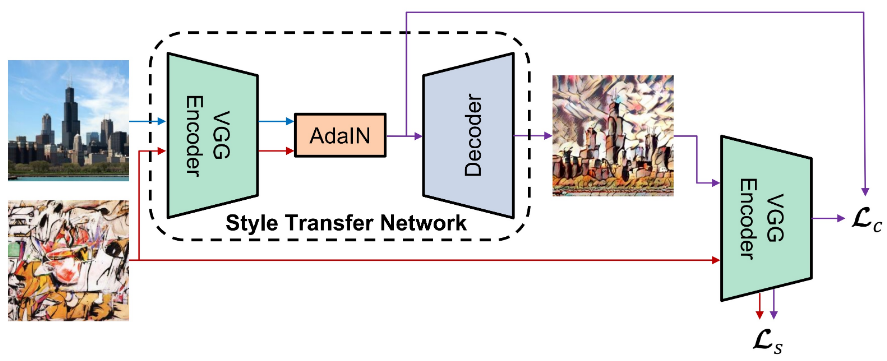

In [ ]:
class Net(nn.Module):
    def __init__(self, encoder, decoder):
        super(Net, self).__init__()
        enc_layers = list(encoder.children())
        self.enc_1 = nn.Sequential(*enc_layers[:4]) # input -> relu1_1
        self.enc_2 = nn.Sequential(*enc_layers[4:11]) # relu1_1 -> relu2_1
        self.enc_3 = nn.Sequential(*enc_layers[11:18]) # relu2_1 -> relu3_1
        self.enc_4 = nn.Sequential(*enc_layers[18:31]) # relu3_1 -> relu4_1
        self.decoder = decoder
        self.mse_loss = nn.MSELoss()

        # fix the encoder
        for name in ['enc_1', 'enc_2', 'enc_3', 'enc_4']:
            for param in getattr(self, name).parameters():
                param.requires_grad = False

    # extract relu1_1, relu2_1, relu3_1, relu4_1 from input image (중간 결과를 기록)
    def encode_with_intermediate(self, input):
        results = [input]
        for i in range(4):
            func = getattr(self, 'enc_{:d}'.format(i + 1))
            results.append(func(results[-1]))
        return results[1:]

    # extract relu4_1 from input image (최종 결과만 기록)
    def encode(self, input):
        for i in range(4):
            input = getattr(self, 'enc_{:d}'.format(i + 1))(input)
        return input

    # 콘텐츠 손실(feature 값 자체가 유사해지도록)
    def calc_content_loss(self, input, target):
        assert (input.size() == target.size())
        assert (target.requires_grad is False)
        return self.mse_loss(input, target)

    # 스타일 손실(feature의 statistics가 유사해지도록)
    def calc_style_loss(self, input, target):
        assert (input.size() == target.size())
        assert (target.requires_grad is False)
        input_mean, input_std = calc_mean_std(input)
        target_mean, target_std = calc_mean_std(target)
        return self.mse_loss(input_mean, target_mean) + self.mse_loss(input_std, target_std)

    def forward(self, content, style, alpha=1.0):
        # 콘텐츠와 스타일 중 어떤 것에 더 많은 가중치를 둘지 설정 가능
        assert 0 <= alpha <= 1 # 0에 가까울수록 콘텐츠를 많이 살림
        style_feats = self.encode_with_intermediate(style)
        content_feat = self.encode(content)
        t = adain(content_feat, style_feats[-1])
        t = alpha * t + (1 - alpha) * content_feat

        g_t = self.decoder(t) # 결과 이미지
        g_t_feats = self.encode_with_intermediate(g_t)

        # 콘텐츠 손실과 스타일 손실을 줄이기 위해 두 개의 손실 값 반환
        loss_c = self.calc_content_loss(g_t_feats[-1], t)
        loss_s = self.calc_style_loss(g_t_feats[0], style_feats[0])
        for i in range(1, 4):
            loss_s += self.calc_style_loss(g_t_feats[i], style_feats[i])
        return loss_c, loss_s

#### <b>실습용 이미지 준비</b>

In [22]:
# 이미지 업로드
from google.colab import files
uploaded = files.upload()

Saving rapunzel.jpg to rapunzel.jpg


In [8]:
# 저장소의 소스코드를 다운로드하여 실습용 이미지 준비하기
!git clone https://github.com/ndb796/Deep-Learning-Paper-Review-and-Practice
%cd Deep-Learning-Paper-Review-and-Practice

Cloning into 'Deep-Learning-Paper-Review-and-Practice'...
remote: Enumerating objects: 449, done.
remote: Counting objects: 100% (188/188), done.
remote: Compressing objects: 100% (188/188), done.
remote: Total 449 (delta 66), reused 0 (delta 0), pack-reused 261
Receiving objects: 100% (449/449), 46.74 MiB | 24.77 MiB/s, done.
Resolving deltas: 100% (146/146), done.
/content/Deep-Learning-Paper-Review-and-Practice


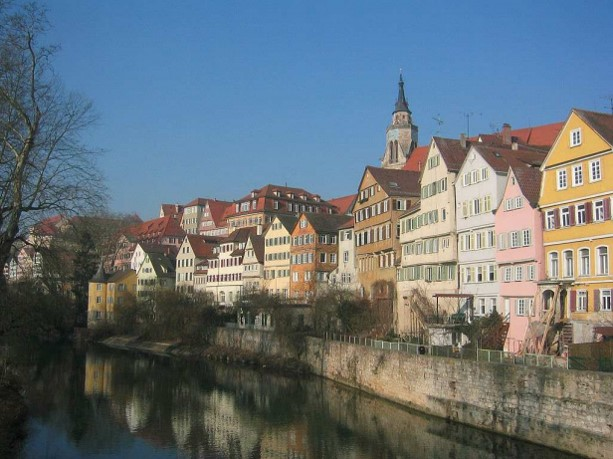

In [9]:
# 콘텐츠(content) 이미지 출력
display_image('./code_practices/images/content_img_1.jpg')

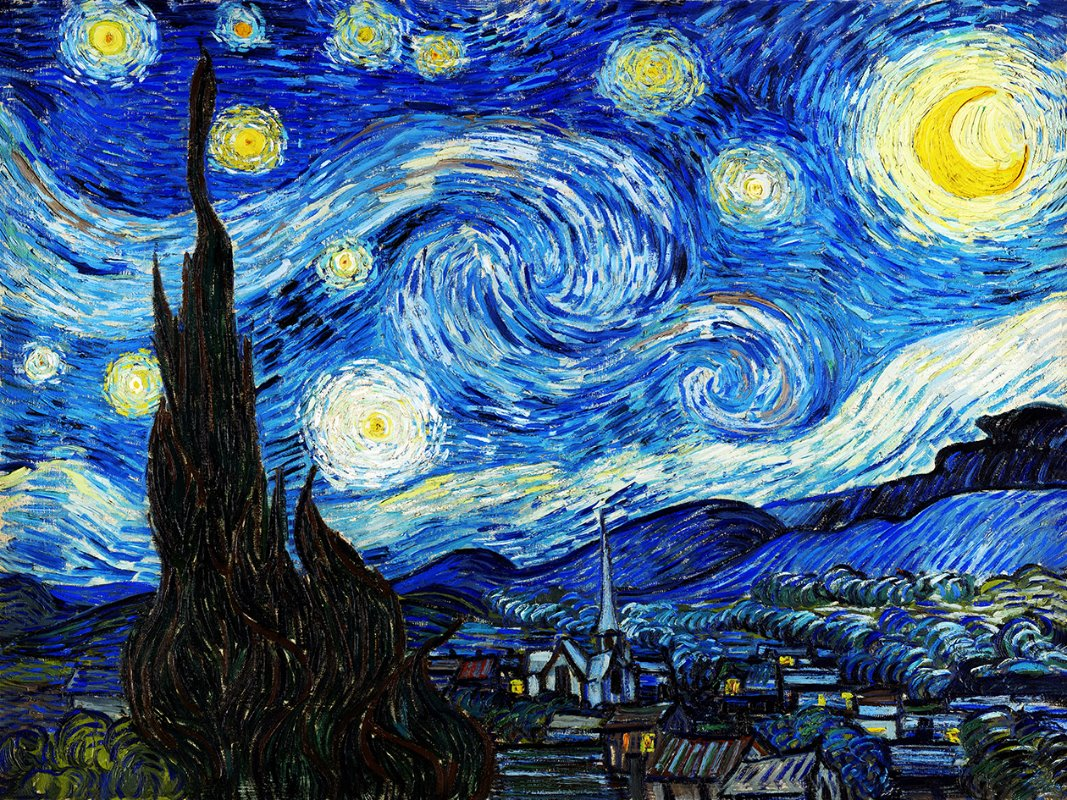

In [10]:
# 스타일(style) 이미지 출력
display_image('./code_practices/images/style_img_1.jpg')

#### <b>스타일 전송(Style Transfer) 함수 구현</b>

* 최종적인 Style Transfer 함수를 구현합니다.

In [11]:
def style_transfer(vgg, decoder, content, style, alpha=1.0):
    assert (0.0 <= alpha <= 1.0)
    content_f = vgg(content)
    style_f = vgg(style)
    feat = adaptive_instance_normalization(content_f, style_f)
    feat = feat * alpha + content_f * (1 - alpha)
    return decoder(feat)

* 이미지 전처리 함수를 구현합니다.

In [12]:
def test_transform(size=512):
    transform_list = []
    if size != 0:
        transform_list.append(transforms.Resize(size))
    transform_list.append(transforms.ToTensor())
    transform = transforms.Compose(transform_list)
    return transform

content_tf = test_transform()
style_tf = test_transform()

#### <b>Style Transfer 실습 ①</b>

* <b>alpha</b> 파라미터를 조절하여 콘텐츠 비율을 증가시킬 수 있습니다.

In [23]:
content_path = './jennie.jpg'
style_path = './rapunzel.jpg'

content = content_tf(Image.open(str(content_path)))
style = style_tf(Image.open(str(style_path)))

style = style.to(device).unsqueeze(0)
content = content.to(device).unsqueeze(0)
with torch.no_grad():
    output = style_transfer(vgg, decoder, content, style, alpha=1.0)
output = output.cpu()

save_image(output, 'output.png')

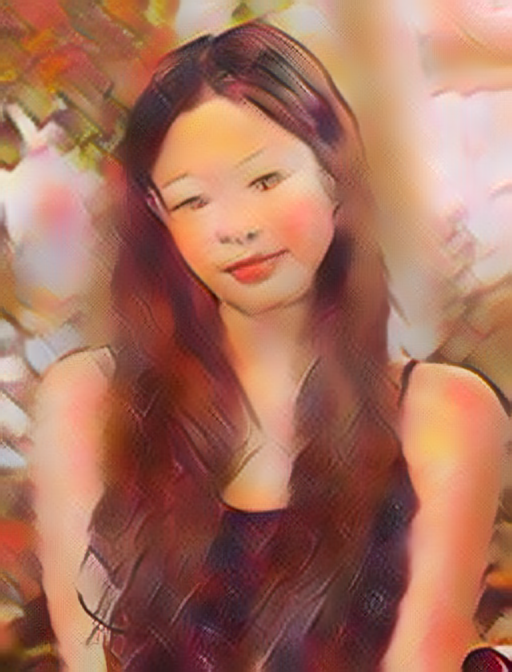

In [24]:
# 결과 이미지 출력
display_image('./output.png')

#### <b>Style Transfer 실습 ②</b>

In [ ]:
content_path = './code_practices/images/content_img_2.jpg'
style_path = './code_practices/images/style_img_2.jpg'

content = content_tf(Image.open(str(content_path)))
style = style_tf(Image.open(str(style_path)))

style = style.to(device).unsqueeze(0)
content = content.to(device).unsqueeze(0)
with torch.no_grad():
    output = style_transfer(vgg, decoder, content, style, alpha=1.0)
output = output.cpu()

save_image(output, 'output.png')

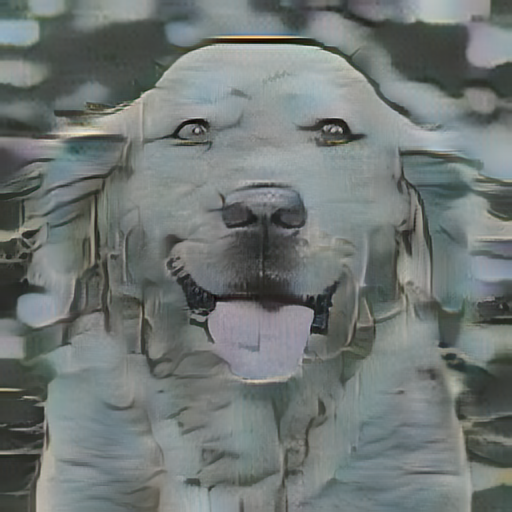

In [ ]:
# 결과 이미지 출력
display_image('./output.png')